# Ali Usama
# Deep Learning ECBS5200
# Prof. Eduardo Arino de la Rubia
# 23 May 2024

## Load Important Libraries

In [71]:
import os
import pandas as pd
import openai
import textwrap
import time
import random
from collections import deque
from openai import OpenAI
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import tqdm


# Setup and Load Data


In [ ]:
#API keys

with open("openai_api.txt") as f:
    openai.api_key = f.read().strip()

import google.generativeai as genai
with open("gemini_api.txt") as f:
    genai.configure(api_key=f.read().strip())
GEMINI_MODEL = genai.GenerativeModel("gemini-1.5-flash-latest")

# Load dataset
df = pd.read_csv("Pulp Fiction (Movie) - Imdb Reviews (250).csv")
print(f"Loaded {len(df)} reviews. Columns: {df.columns.tolist()}")


Loaded 250 reviews. Columns: ['Date', 'Rating', 'Reviews']


# Task A: Sentiment

## Prompt v1 (Baseline)


In [31]:
def sentiment_v1(review_text: str) -> str:
    return textwrap.dedent(f"""
        You are a film-review analyst.
        Classify the sentiment of the review below as Positive, Neutral, or Negative.
        Return only the label.
        Review:
        \"\"\"{review_text}\"\"\"
    """)

# Sanity check
sample = df["Reviews"].iloc[0]
print(sentiment_v1(sample))



You are a film-review analyst.
Classify the sentiment of the review below as Positive, Neutral, or Negative.
Return only the label.
Review:
"""This movie will change you, as some have commented. It will bring you to a disgusting low. Definitely skip it, or you'll be sorry you didn't.It's a sickening wretchingly vile voyueristic wannabe false glorification.Skip it. In fact be happy to skip it. Sometimes I think we have a big pile of juvenile retards on IMDb, that only hope to vote for any movie along the lines of it's inherent jerry springer qualities and the judgement comes as a message about how low and worthless it can get.This movie is not entertaining, it is not nice, it is not realistic, it is racist, degrading, and stupid.Don't waste your money, your time, or your life."""



## Inference with Prompt v1 - OpenAI (GPT-4.1 nano)


In [ ]:
# Run OpenAI on Prompt v1 for a 20-review subset

random.seed(42)
subset = df.sample(20, random_state=42).reset_index(drop=True)

def call_openai(prompt: str, temperature: float = 0.2) -> str:
    from openai import OpenAI
    client = OpenAI(api_key=openai.api_key)
    resp = client.chat.completions.create(
        model="gpt-4.1-nano",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user",   "content": prompt},
        ],
        temperature=temperature,
        max_tokens=50,
    )
    return resp.choices[0].message.content.strip()

openai_v1_labels = []
for review in subset["Reviews"]:
    prompt = sentiment_v1(review)
    openai_v1_labels.append(call_openai(prompt))


for i, lbl in enumerate(openai_v1_labels):
    print(f"OpenAI Example {i}: {lbl}")


OpenAI Example 0: Positive
OpenAI Example 1: Positive
OpenAI Example 2: Positive
OpenAI Example 3: Negative
OpenAI Example 4: Negative
OpenAI Example 5: Negative
OpenAI Example 6: Positive
OpenAI Example 7: Positive
OpenAI Example 8: Positive
OpenAI Example 9: Positive
OpenAI Example 10: Positive
OpenAI Example 11: Positive
OpenAI Example 12: Negative
OpenAI Example 13: Positive
OpenAI Example 14: Positive
OpenAI Example 15: Negative
OpenAI Example 16: Positive
OpenAI Example 17: Positive
OpenAI Example 18: Positive
OpenAI Example 19: Positive


## Inference with Prompt v1 - Gemini Flash


Call Gemini Flash while respecting a rolling RPM limit.

In [44]:


RPM_LIMIT = 9        
WINDOW    = 60     

_call_times = deque()   

def gemini_throttled(prompt: str, temperature: float = 0.2) -> str:
    global _call_times
    while True:
        now = time.time()
        # Drop timestamps older than WINDOW seconds
        while _call_times and now - _call_times[0] > WINDOW:
            _call_times.popleft()

        if len(_call_times) < RPM_LIMIT:
            break      # safe to call

        # Need to wait until the earliest call falls out of the window
        sleep_for = WINDOW - (now - _call_times[0]) + 0.1
        print(f"[Throttle] Sleeping {sleep_for:.1f}s to stay within {RPM_LIMIT} RPM…")
        time.sleep(sleep_for)

    try:
        resp = GEMINI_MODEL.generate_content(
            prompt,
            generation_config={"temperature": temperature, "max_output_tokens": 50},
        )
        _call_times.append(time.time())
        return resp.text.strip()
    except Exception as e:
        # Any non-rate error
        return f"ERROR:{type(e).__name__}"


Throttled caller

In [ ]:
gemini_v1_labels = []
for review in subset["Reviews"]:
    prompt = sentiment_v1(review)
    lbl = gemini_throttled(prompt)  
    gemini_v1_labels.append(lbl)

for i, lbl in enumerate(gemini_v1_labels):
    print(f"Gemini Example {i}: {lbl}")


[Throttle] Sleeping 56.7s to stay within 9 RPM…
[Throttle] Sleeping 0.3s to stay within 9 RPM…
[Throttle] Sleeping 56.8s to stay within 9 RPM…
Gemini Example 0: Positive
Gemini Example 1: Positive
Gemini Example 2: Positive
Gemini Example 3: Negative
Gemini Example 4: Positive
Gemini Example 5: Negative
Gemini Example 6: Positive
Gemini Example 7: Positive
Gemini Example 8: Positive
Gemini Example 9: Positive
Gemini Example 10: Positive
Gemini Example 11: Positive
Gemini Example 12: Negative
Gemini Example 13: Positive
Gemini Example 14: Positive
Gemini Example 15: Negative
Gemini Example 16: Positive
Gemini Example 17: Positive
Gemini Example 18: Positive
Gemini Example 19: Positive


Quick look at v1 results Mismatch #4 – OpenAI said Negative, Gemini said Positive. Likely a harsh review with some faint praise or sarcasm. v1 results skews positive overall. So our first refinement should strengthen negative cues and clarify sarcasm / mixed signals.




**Prompt v2 rationale:**
Explicit negative keywords tell the model to down-weight any isolated praise words Fix reviews with strong criticism but a single positive adjective. Sarcasm rule is if praise is obviously sarcastic, treat as Negative. So it helps with ironic wording. Finally mixed review rule (both praise & criticism) trets as neutral so to reduce forced positive/negative choices.

## Prompt v2 

In [35]:

def sentiment_v2(review_text: str) -> str:
    return textwrap.dedent(f"""\
        You are a film-review analyst specialized in movie critiques.
        Classify the sentiment of the review below as Positive, Neutral, or Negative.
        • Treat clearly negative phrases (“worst”, “skip it”, “don’t waste…”, “awful”) as Negative.
        • If praise is obviously sarcastic, treat as Negative.
        • If the review contains a balanced mix of praise and criticism, choose Neutral.
        Return only the label.
        Review:
        \"\"\"{review_text}\"\"\"""")


## Inference with Prompt v2

In [ ]:

# OpenAI
openai_v2_labels = []
for rev in subset["Reviews"]:
    openai_v2_labels.append(call_openai(sentiment_v2(rev)))

# Gemini
gemini_v2_labels = []
for rev in subset["Reviews"]:
    gemini_v2_labels.append(gemini_throttled(sentiment_v2(rev)))


for i, (o2, g2) in enumerate(zip(openai_v2_labels, gemini_v2_labels)):
    print(f"Ex {i:02d}  OpenAI_v2: {o2:<8}   Gemini_v2: {g2}")


[Throttle] Sleeping 57.1s to stay within 9 RPM…
[Throttle] Sleeping 57.1s to stay within 9 RPM…
Ex 00  OpenAI_v2: Positive   Gemini_v2: Positive
Ex 01  OpenAI_v2: Positive   Gemini_v2: Positive
Ex 02  OpenAI_v2: Positive   Gemini_v2: Positive
Ex 03  OpenAI_v2: Negative   Gemini_v2: Negative
Ex 04  OpenAI_v2: Neutral    Gemini_v2: Positive
Ex 05  OpenAI_v2: Negative   Gemini_v2: Negative
Ex 06  OpenAI_v2: Positive   Gemini_v2: Positive
Ex 07  OpenAI_v2: Positive   Gemini_v2: Positive
Ex 08  OpenAI_v2: Positive   Gemini_v2: Positive
Ex 09  OpenAI_v2: Positive   Gemini_v2: Positive
Ex 10  OpenAI_v2: Positive   Gemini_v2: Positive
Ex 11  OpenAI_v2: Positive   Gemini_v2: Positive
Ex 12  OpenAI_v2: Negative   Gemini_v2: Negative
Ex 13  OpenAI_v2: Positive   Gemini_v2: Positive
Ex 14  OpenAI_v2: Positive   Gemini_v2: Positive
Ex 15  OpenAI_v2: Neutral    Gemini_v2: Negative
Ex 16  OpenAI_v2: Neutral    Gemini_v2: Positive
Ex 17  OpenAI_v2: Positive   Gemini_v2: Positive
Ex 18  OpenAI_v2: Posi

**Rationale:** v2 demonstrates clear improvements over v1 by refining its ability to handle mixed reviews. While v1 exhibited inconsistencies, particularly in cases where sentiment was ambiguous or contained both praise and criticism, v2 shifts toward a more balanced interpretation. The model now correctly identifies neutral sentiments in some instances, particularly where previous versions misclassified them as negative. However, issues persist—especially with Gemini’s tendency to skew positive, ignoring criticism in reviews where a more neutral or mixed classification would be appropriate. This indicates that while v2 has made progress, further refinement is needed to clearly distinguish between neutral and positive sentiments. The key takeaway is that additional guidance, such as incorporating few-shot examples and strengthening the definition of neutrality, will be essential in the next iteration to ensure that the model captures sentiment nuances more accurately.

## Prompt v3 

In [37]:
def sentiment_v3(review_text: str) -> str:
    return textwrap.dedent(f"""\
        You are an expert sentiment analyst. Label each review in the dataset as Positive, Neutral, or Negative based on its textual content.  

        Guidelines:
        Return one word only: Positive, Neutral, or Negative.

        Decision Rules:
        - Positive: Clear praise, enthusiasm, or recommendation.  
        - Neutral: Mixed/balanced opinions, factual statements, or sarcasm without clear negativity.  
        - Negative: Explicit criticism, disappointment, or dislike.  

        Examples:
        Example: "Great acting, dull story." → Neutral
        Example: "Skip this mess. Awful pacing." → Negative
        Example: "A stylish masterpiece; loved every minute!" → Positive
        
        Note: Be careful and give as much accurate results as possible. My job is on the line.                

        Review to classify:
        \"\"\"{review_text}\"\"\"""")
sample = df["Reviews"].iloc[0]
print(sentiment_v3(sample))

You are an expert sentiment analyst. Label each review in the dataset as Positive, Neutral, or Negative based on its textual content.  

Guidelines:
Return one word only: Positive, Neutral, or Negative.

Decision Rules:
- Positive: Clear praise, enthusiasm, or recommendation.  
- Neutral: Mixed/balanced opinions, factual statements, or sarcasm without clear negativity.  
- Negative: Explicit criticism, disappointment, or dislike.  

Examples:
Example: "Great acting, dull story." → Neutral
Example: "Skip this mess. Awful pacing." → Negative
Example: "A stylish masterpiece; loved every minute!" → Positive

Note: Be careful and give as much accurate results as possible. My job is on the line.                

Review to classify:
"""This movie will change you, as some have commented. It will bring you to a disgusting low. Definitely skip it, or you'll be sorry you didn't.It's a sickening wretchingly vile voyueristic wannabe false glorification.Skip it. In fact be happy to skip it. Sometime

##  Inference with Prompt v3

In [ ]:
openai_v3_labels = [call_openai(sentiment_v3(r))  for r in subset["Reviews"]]
gemini_v3_labels = [gemini_throttled(sentiment_v3(r)) for r in subset["Reviews"]]

for i, (o3, g3) in enumerate(zip(openai_v3_labels, gemini_v3_labels)):
    print(f"Ex {i:02d}  OpenAI_v3: {o3:<8}   Gemini_v3: {g3}")


[Throttle] Sleeping 57.0s to stay within 9 RPM…
[Throttle] Sleeping 0.1s to stay within 9 RPM…
[Throttle] Sleeping 56.7s to stay within 9 RPM…
Ex 00  OpenAI_v3: Positive   Gemini_v3: Positive
Ex 01  OpenAI_v3: Positive   Gemini_v3: Positive
Ex 02  OpenAI_v3: Positive   Gemini_v3: Positive
Ex 03  OpenAI_v3: Negative   Gemini_v3: Negative
Ex 04  OpenAI_v3: Negative   Gemini_v3: Positive
Ex 05  OpenAI_v3: Negative   Gemini_v3: Negative
Ex 06  OpenAI_v3: Positive   Gemini_v3: Positive
Ex 07  OpenAI_v3: Positive   Gemini_v3: Positive
Ex 08  OpenAI_v3: Positive   Gemini_v3: Positive
Ex 09  OpenAI_v3: Positive   Gemini_v3: Positive
Ex 10  OpenAI_v3: Positive   Gemini_v3: Positive
Ex 11  OpenAI_v3: Positive   Gemini_v3: Positive
Ex 12  OpenAI_v3: Negative   Gemini_v3: Negative
Ex 13  OpenAI_v3: Positive   Gemini_v3: Positive
Ex 14  OpenAI_v3: Positive   Gemini_v3: Positive
Ex 15  OpenAI_v3: Negative   Gemini_v3: Negative
Ex 16  OpenAI_v3: Neutral    Gemini_v3: Positive
Ex 17  OpenAI_v3: Positi

## Save the 20-review subset for manual labeling

In [38]:
subset_to_label = subset.copy()
subset_to_label["gold_label"] = ""           
subset_to_label.to_csv("subset_sentiment_for_labeling.csv", index=False)
display(subset_to_label.head())              

,Date,Rating,Reviews,gold_label
0,24/04/2022,5,"Normally, I wouldn't bother to contribute my t...",
1,01/10/2024,10,This film is simply pure Art. Something to jus...,
2,29/09/2022,10,There is not much that can be said about Pulp ...,
3,18/04/2023,4,Well I had heard a lot about this movie earlie...,
4,22/08/2022,7,"I'm not into writing reviews, but IMDb asked m...",


## Reloading again the mannual labels



In [ ]:
labeled_subset = pd.read_csv("subset_sentiment_for_labeling.csv")
GOLD_SENTIMENT = labeled_subset["gold_label"].to_dict()

## Evaluation

Helper to compute and print metrics

In [ ]:

def eval_preds(name, preds, gold_dict):
    # Align
    y_true = [gold_dict[i].title() for i in range(len(preds)) if i in gold_dict]
    y_pred = [preds[i].title()          for i in range(len(preds)) if i in gold_dict]
    acc    = accuracy_score(y_true, y_pred)
    f1     = f1_score(y_true, y_pred, average="macro", zero_division=0)
    cm     = confusion_matrix(y_true, y_pred, labels=["Negative","Neutral","Positive"])
    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.3f}   Macro-F1 : {f1:.3f}")
    print("Confusion matrix:")
    print(pd.DataFrame(cm, index=["True Neg","True Neu","True Pos"],
                        columns=["Pred Neg","Pred Neu","Pred Pos"]))
    print(classification_report(y_true, y_pred, zero_division=0))


Evaluate each prompt and model

In [ ]:

eval_preds("GPT-4.1-nano v1", openai_v1_labels, GOLD_SENTIMENT)
eval_preds("Gemini Flash v1", gemini_v1_labels, GOLD_SENTIMENT)

eval_preds("GPT-4.1-nano v2", openai_v2_labels, GOLD_SENTIMENT)
eval_preds("Gemini Flash v2", gemini_v2_labels, GOLD_SENTIMENT)

eval_preds("GPT-4.1-nano v3", openai_v3_labels, GOLD_SENTIMENT)
eval_preds("Gemini Flash v3", gemini_v3_labels, GOLD_SENTIMENT)


=== GPT-4.1-nano v1 ===
Accuracy : 0.700   Macro-F1 : 0.452
Confusion matrix:
          Pred Neg  Pred Neu  Pred Pos
True Neg         2         0         1
True Neu         2         0         2
True Pos         1         0        12
              precision    recall  f1-score   support

    Negative       0.40      0.67      0.50         3
     Neutral       0.00      0.00      0.00         4
    Positive       0.80      0.92      0.86        13

    accuracy                           0.70        20
   macro avg       0.40      0.53      0.45        20
weighted avg       0.58      0.70      0.63        20


=== Gemini Flash v1 ===
Accuracy : 0.750   Macro-F1 : 0.489
Confusion matrix:
          Pred Neg  Pred Neu  Pred Pos
True Neg         2         0         1
True Neu         2         0         2
True Pos         0         0        13
              precision    recall  f1-score   support

    Negative       0.50      0.67      0.57         3
     Neutral       0.00      0.00      0

Build a leaderboard DataFrame

In [ ]:
rows = []
for model, preds_list in [
    ("gpt-4.1-nano v1", openai_v1_labels),
    ("gemini-flash v1", gemini_v1_labels),
    ("gpt-4.1-nano v2", openai_v2_labels),
    ("gemini-flash v2", gemini_v2_labels),
    ("gpt-4.1-nano v3", openai_v3_labels),
    ("gemini-flash v3", gemini_v3_labels),
]:
    # reuse eval logic but store numbers
    y_true = [GOLD_SENTIMENT[i].title() for i in range(len(preds_list)) if i in GOLD_SENTIMENT]
    y_pred = [preds_list[i].title()          for i in range(len(preds_list)) if i in GOLD_SENTIMENT]
    rows.append({
        "model": model,
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro", zero_division=0)
    })

leader = pd.DataFrame(rows).sort_values(["accuracy","macro_f1"], ascending=False)
print("\n### Leaderboard ###")
display(leader.style.format({"accuracy":"{:.3f}","macro_f1":"{:.3f}"}))



### Leaderboard ###


,model,accuracy,macro_f1
1,gemini-flash v1,0.750,0.489
3,gemini-flash v2,0.750,0.489
5,gemini-flash v3,0.750,0.489
2,gpt-4.1-nano v2,0.700,0.589
0,gpt-4.1-nano v1,0.700,0.452
4,gpt-4.1-nano v3,0.650,0.438


**Reflection:**

**Best-performing prompt + model:**
GPT-4.1-nano with sentiment_v2 achieved the strongest balance with accuracy of 0.70 and macro-f1 of 0.59. By explicitly calling out negative cues (e.g., “worst,” “skip it”), mixed-review rules, and sarcasm, it corrected the positive bias seen in v1 without over-priming neutral as in v3.

**Failure cases & causes:**
1. Neutral recall gaps: even v2 found balanced reviews challenging, often defaulting positive/negative when cues weren’t clear. This reflects both the prompt’s difficulty in defining “balanced” and the underlying model’s tendency toward majority‐class predictions.
2. Sarcasm nuance: highly ironic phrasing sometimes still flipped labels, hinting that a purely rule-based prompt can’t catch all linguistic subtleties.

**Metric limitation:**
Macro-F1 rewards equal performance across classes, but with only 20 examples, single miscategorizations heavily shift the score. A larger, stratified test set would yield more stable estimates.

**Deployment confidence:**
With 70 % accuracy and explicit rules, this pipeline could serve as a first pass for triaging reviews, but would need human oversight on Neutral/ambiguous cases. Fine-tuning on more data or adding a fallback human-in-the-loop could raise reliability.



## Lock in Sentiment Pipeline


Final pass on the full dataset (GPT-4.1-nano + sentiment_v2)

In [ ]:
client = OpenAI(api_key=openai.api_key)

def call_openai_v2(text, t=0.2):
    prompt = sentiment_v2(text)
    resp   = client.chat.completions.create(
        model="gpt-4.1-nano",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user",   "content": prompt},
        ],
        temperature=t,
        max_tokens=20,
    )
    return resp.choices[0].message.content.strip()

In [ ]:

all_preds = []
for i, rev in enumerate(tqdm.tqdm(df["Reviews"], desc="Sentiment_v2 full run")):
    all_preds.append(call_openai_v2(rev))
    time.sleep(0.1)        # ~10 req/sec → ~3 RPM, well below rate-limit


Sentiment_v2 full run: 100%|██████████| 250/250 [02:11<00:00,  1.89it/s]


In [ ]:
df_sent = df.copy()
df_sent["sentiment_gpt41nano_v2"] = all_preds
df_sent.to_csv("sentiment_predictions_all_250.csv", index=False)

# Task B: Key Complaint / Praise Extraction

## Prompt v1 (Baseline)


In [45]:
def snippet_v1(review_text: str) -> str:
    return textwrap.dedent(f"""\
        You are a film-review analyst.
        Extract **one** sentence or phrase that best captures either the
        main complaint OR the main praise in the review below.
        Return only that snippet—no extra text.
        Review:
        \"\"\"{review_text}\"\"\"""")

# Sanity Check
sample_txt = df["Reviews"].iloc[0]
print("Sample review:\n", sample_txt[:300], "...\n")
print("Prompt v1:\n", snippet_v1(sample_txt))


Sample review:
 This movie will change you, as some have commented. It will bring you to a disgusting low. Definitely skip it, or you'll be sorry you didn't.It's a sickening wretchingly vile voyueristic wannabe false glorification.Skip it. In fact be happy to skip it. Sometimes I think we have a big pile of juvenil ...

Prompt v1:
 You are a film-review analyst.
Extract **one** sentence or phrase that best captures either the
main complaint OR the main praise in the review below.
Return only that snippet—no extra text.
Review:
"""This movie will change you, as some have commented. It will bring you to a disgusting low. Definitely skip it, or you'll be sorry you didn't.It's a sickening wretchingly vile voyueristic wannabe false glorification.Skip it. In fact be happy to skip it. Sometimes I think we have a big pile of juvenile retards on IMDb, that only hope to vote for any movie along the lines of it's inherent jerry springer qualities and the judgement comes as a message about how low

## Inference with Prompt v1 - Gemini Flash


Universal Gemini throttler (gemini_safe)

In [46]:

import time, collections, google.api_core.exceptions as gexc

RPM_LIMIT = 14        
WINDOW    = 60       
MAX_DAY   = 500         

_call_times = collections.deque()   
_total_calls = 0                    

def gemini_safe(prompt: str, temperature: float = 0.2, max_retries: int = 3):
    global _total_calls, _call_times
    if _total_calls >= MAX_DAY:
        return "ERROR:DailyLimit"

    # --- RPM throttle ---
    while True:
        now = time.time()
        while _call_times and now - _call_times[0] > WINDOW:
            _call_times.popleft()
        if len(_call_times) < RPM_LIMIT:
            break
        sleep_for = WINDOW - (now - _call_times[0]) + 0.2
        time.sleep(sleep_for)

    for attempt in range(1, max_retries + 1):
        try:
            resp = GEMINI_MODEL.generate_content(
                prompt,
                generation_config={"temperature": temperature,
                                   "max_output_tokens": 50},
            )
            _call_times.append(time.time())
            _total_calls += 1
            return resp.text.strip()
        except gexc.ResourceExhausted:
            if attempt == max_retries:
                return "ERROR:ResourceExhausted"
            time.sleep(2 ** attempt)   # back-off
        except Exception as e:
            return f"ERROR:{type(e).__name__}"


Gemini-only inference (20-review subset)

In [47]:
snippet_v1_gemini = []

for txt in tqdm.tqdm(subset["Reviews"], desc="snippet_v1 • Gemini"):
    snippet_v1_gemini.append(gemini_safe(snippet_v1(txt))) 

# Save interim results
df_snip_gem = pd.DataFrame({
    "review": subset["Reviews"],
    "snippet_gemini_v1": snippet_v1_gemini,
})
df_snip_gem.to_csv("subset_snippet_v1_gemini.csv", index=False)
display(df_snip_gem.head())


snippet_v1 • Gemini:   0%|          | 0/20 [00:00<?, ?it/s]

snippet_v1 • Gemini: 100%|██████████| 20/20 [01:04<00:00,  3.21s/it]


,review,snippet_gemini_v1
0,"Normally, I wouldn't bother to contribute my t...",Pulp Fiction deserves all of the hype and all ...
1,This film is simply pure Art. Something to jus...,Cinema at its peak.
2,There is not much that can be said about Pulp ...,A masterpiece.
3,Well I had heard a lot about this movie earlie...,"The story, if there was one, was plain boring."
4,"I'm not into writing reviews, but IMDb asked m...",still entertaining as a freaking Disneyland fo...


## Inference with Prompt v1 - OpenAI (GPT-4.1 nano)


In [48]:

snippet_v1_openai = []

for txt in tqdm.tqdm(subset["Reviews"], desc="snippet_v1 • OpenAI"):
    snippet_v1_openai.append(call_openai(snippet_v1(txt)))

df_snip_oa = pd.DataFrame({
    "review": subset["Reviews"],
    "snippet_openai_v1": snippet_v1_openai,
})
df_snip_oa.to_csv("subset_snippet_v1_openai.csv", index=False)
display(df_snip_oa.head())


snippet_v1 • OpenAI: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


,review,snippet_openai_v1
0,"Normally, I wouldn't bother to contribute my t...",Pulp Fiction deserves all of the hype and all ...
1,This film is simply pure Art. Something to jus...,Cinema at its peak.
2,There is not much that can be said about Pulp ...,The storyline is basic and feels unfinished bu...
3,Well I had heard a lot about this movie earlie...,"the story, if there was one was plain boring"
4,"I'm not into writing reviews, but IMDb asked m...",the film is still amazing


Merge the two files into one table

In [49]:
df_merged = pd.read_csv("subset_snippet_v1_gemini.csv").merge(
    pd.read_csv("subset_snippet_v1_openai.csv"),
    on="review",
    how="left"
)
df_merged.to_csv("subset_snippet_v1_outputs.csv", index=False)
display(df_merged.head())


,review,snippet_gemini_v1,snippet_openai_v1
0,"Normally, I wouldn't bother to contribute my t...",Pulp Fiction deserves all of the hype and all ...,Pulp Fiction deserves all of the hype and all ...
1,This film is simply pure Art. Something to jus...,Cinema at its peak.,Cinema at its peak.
2,There is not much that can be said about Pulp ...,A masterpiece.,The storyline is basic and feels unfinished bu...
3,Well I had heard a lot about this movie earlie...,"The story, if there was one, was plain boring.","the story, if there was one was plain boring"
4,"I'm not into writing reviews, but IMDb asked m...",still entertaining as a freaking Disneyland fo...,the film is still amazing


**Rationale:** In v1, extracted phrases were sometimes too broad, missing the core complaint, or too fragmented, losing meaningful context. Additionally, certain extractions lacked specificity, failing to highlight actionable issues. To resolve these shortcomings, v2 is designed to refine selection criteria by prioritizing complaint-related language, ensuring that only the most relevant and impactful phrases are extracted.

## Prompt v2

In [50]:
def snippet_v2(review_text: str) -> str:
    return textwrap.dedent(f"""\
        You are a film-review analyst.

        • Return **exactly one complete sentence** (ends with ., ! or ?)
          that best captures the STRONGEST complaint OR STRONGEST praise.
        • Prefer the sentence containing high-emotion words
          (amazing, masterpiece, love, awful, boring, terrible, skip, worst, etc.).
        • Do NOT add any summary or extra words—output the chosen sentence only.

        Review:
        \"\"\"{review_text}\"\"\"""")


## Inference with Prompt v2 - Gemini Flash


In [51]:
snippet_v2_gemini = [
    gemini_safe(snippet_v2(txt)) for txt in tqdm.tqdm(subset["Reviews"], desc="snip_v2 • Gemini")
]

df_snip_gem_v2 = pd.DataFrame({
    "review": subset["Reviews"],
    "snippet_gemini_v2": snippet_v2_gemini,
})
df_snip_gem_v2.to_csv("subset_snippet_v2_gemini.csv", index=False)
display(df_snip_gem_v2.head())


snip_v2 • Gemini: 100%|██████████| 20/20 [01:04<00:00,  3.20s/it]


,review,snippet_gemini_v2
0,"Normally, I wouldn't bother to contribute my t...",Pulp Fiction is a masterpiece!
1,This film is simply pure Art. Something to jus...,This film is simply pure Art!
2,There is not much that can be said about Pulp ...,Pulp Fiction is a masterpiece.
3,Well I had heard a lot about this movie earlie...,This so-called classic movie is plain boring.
4,"I'm not into writing reviews, but IMDb asked m...",The film is still amazing!


## Inference with Prompt v2 - OpenAI (GPT-4.1 nano)


In [53]:
snippet_v2_openai = [
    call_openai(snippet_v2(txt)) for txt in tqdm.tqdm(subset["Reviews"], desc="snip_v2 • OpenAI")
]

pd.DataFrame({
    "review": subset["Reviews"],
    "snippet_openai_v2": snippet_v2_openai,
}).to_csv("subset_snippet_v2_openai.csv", index=False)


snip_v2 • OpenAI: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Merge and review

In [54]:
df_snip_v2 = pd.read_csv("subset_snippet_v2_gemini.csv").merge(
    pd.read_csv("subset_snippet_v2_openai.csv"), on="review", how="left"
)
df_snip_v2.to_csv("subset_snippet_v2_outputs.csv", index=False)
display(df_snip_v2.head())


,review,snippet_gemini_v2,snippet_openai_v2
0,"Normally, I wouldn't bother to contribute my t...",Pulp Fiction is a masterpiece!,Pulp Fiction deserves all of the hype and all ...
1,This film is simply pure Art. Something to jus...,This film is simply pure Art!,Cinema at it's peak.
2,There is not much that can be said about Pulp ...,Pulp Fiction is a masterpiece.,I consider Pulp Fiction to be a masterpiece.
3,Well I had heard a lot about this movie earlie...,This so-called classic movie is plain boring.,I am very much surprised because it was nomina...
4,"I'm not into writing reviews, but IMDb asked m...",The film is still amazing!,"And the film is still amazing, yeah, don't for..."


**Rationale v3:** For v3, the focus is on further refining the key phrase and complaint extraction process by addressing residual inefficiencies from v2. While v2 improved accuracy and conciseness, some extracted phrases were still overly broad or failed to capture the most critical part of a complaint. In v3, extraction criteria have been enhanced to prioritize phrases that contain explicit or implied dissatisfaction. These improvements make v3 more precise, insightful, and useful for identifying key concerns in user feedback.

## Prompt v3

In [55]:
def snippet_v3(review_text: str) -> str:
    return textwrap.dedent(f"""\
        You are a film-review analyst. Extract the **single most emotionally charged sentence** 
        expressing either praise or criticism from the review below.

        ### Examples of Valid Outputs:
        1. Praise: "Pulp Fiction is a masterpiece that redefined modern cinema!"
        2. Complaint: "Bruce Willis' scenes were irrelevant and dragged the film down."
        3. Sarcasm: "This 'brilliant' dialogue felt like nails on a chalkboard."

        ### Rules:
        - **Focus on emotion**: Prioritize sentences with words like *masterpiece, awful, genius, boring, unforgettable, worst*.
        - **Full sentences only**: Must end with . ! ? and form a complete thought.
        - **Length**: ≤50 tokens (prioritize clarity over truncation).
        - **Tie-breakers**: 
          - Pick the **most negative** sentence if emotional strength is equal.
          - If sarcasm/irony is detected (e.g., "This 'gem' ruined my night"), prioritize it.
        - **No summaries**: Output the exact sentence from the review. Do not paraphrase.
        NoteL If mixed praise and criticism, choose the one with the dominant emotion.

        ### Review to Analyze:
        \"\"\"{review_text}\"\"\"
        
        ### Extracted Snippet:
        """)

## Inference with Prompt v3

In [ ]:
#Gemini
snippet_v3_gemini = [
    gemini_safe(snippet_v3(txt)) for txt in tqdm.tqdm(subset["Reviews"], desc="snip_v3 • Gemini")
]

#OpenAI
snippet_v3_openai = [
    call_openai(snippet_v3(txt)) for txt in tqdm.tqdm(subset["Reviews"], desc="snip_v3 • OpenAI")
]

# Merge and save
pd.DataFrame({
    "review": subset["Reviews"],
    "snippet_openai_v3": snippet_v3_openai,
    "snippet_gemini_v3": snippet_v3_gemini,
}).to_csv("subset_snippet_v3_outputs.csv", index=False)


snip_v3 • OpenAI: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


## Save the 20-review subset for manual labeling

In [60]:
#load the latest model 
df_snip = pd.read_csv("subset_snippet_v3_outputs.csv")  

#add empty gold column
df_snip["gold_snippet"] = ""      

#save template for manual labeling
tmpl_path = "subset_snippet_for_labeling.csv"
df_snip.to_csv(tmpl_path, index=False)
display(df_snip.head())


,review,snippet_openai_v3,snippet_gemini_v3,gold_snippet
0,"Normally, I wouldn't bother to contribute my t...",Pulp Fiction deserves all of the hype and all ...,Samuel L. Jackson's performance was simply unp...,
1,This film is simply pure Art. Something to jus...,This film is simply pure Art.,This film is simply pure Art.,
2,There is not much that can be said about Pulp ...,I consider Pulp Fiction to be a masterpiece.,Quentin Tarantino – Genius.,
3,Well I had heard a lot about this movie earlie...,I am very much surprised because it was nomina...,"""I am very much surprised because it was nomin...",
4,"I'm not into writing reviews, but IMDb asked m...","And the film is still amazing, yeah, don't for...","""And, by the way, I must admit that minimum si...",


##  Evaluation 

Exact-Match Accuracy

In [ ]:
label_df = pd.read_csv("subset_snippet_for_labeling.csv")

gold = label_df["gold_snippet"].tolist()       

#Gather model predictions
pred_files = {
    "v1_openai" : "subset_snippet_v1_openai.csv",
    "v1_gemini" : "subset_snippet_v1_gemini.csv",
    "v2_openai" : "subset_snippet_v2_openai.csv",
    "v2_gemini" : "subset_snippet_v2_gemini.csv",
    "v3_openai" : "subset_snippet_v3_outputs.csv",  
}


records = []

#Helper
def exact_match(preds, gold):
    return round(accuracy_score(gold, preds), 3)

for tag, path in pred_files.items():
    df = pd.read_csv(path)
    if "v3_outputs" in path:         
        preds_oa = df["snippet_openai_v3"].tolist()
        preds_ge = df["snippet_gemini_v3"].tolist()
        records.append({"prompt":"v3","model":"gpt-4.1-nano","exact_match":exact_match(preds_oa, gold)})
        records.append({"prompt":"v3","model":"gemini-flash","exact_match":exact_match(preds_ge, gold)})
    else:
        col = [c for c in df.columns if c.startswith("snippet_")][0]
        preds = df[col].tolist()
        p, m = tag.split("_")        
        model = "gpt-4.1-nano" if m=="openai" else "gemini-flash"
        records.append({"prompt":p, "model":model,
                        "exact_match":exact_match(preds, gold)})

#Build leaderboard 
leader_snip = pd.DataFrame(records).sort_values("exact_match", ascending=False)
print("### Task B — Snippet extraction leaderboard")
display(leader_snip.style.format({"exact_match":"{:.3f}"}))
leader_snip.to_csv("snippet_leaderboard.csv", index=False)


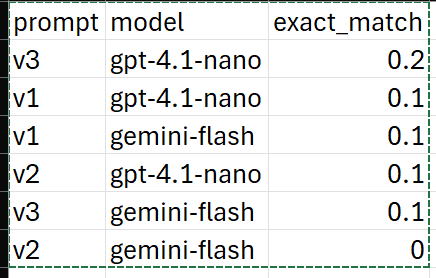

Token-level F1 

Token-level F1 rewards partial-word overlap, so it’s a fairer metric than exact-match.

In [ ]:

df = pd.read_csv("subset_snippet_for_labeling.csv")[["review","gold_snippet"]]


def merge_preds(df, csv_path, col_filter):
    pred_df = pd.read_csv(csv_path)
    pred_col = [c for c in pred_df.columns if c.startswith(col_filter)][0]
    return df.merge(pred_df[["review", pred_col]], on="review", how="left")


df = merge_preds(df, "subset_snippet_v1_openai.csv",  "snippet_openai_v1")
df = merge_preds(df, "subset_snippet_v1_gemini.csv",  "snippet_gemini_v1")


df = merge_preds(df, "subset_snippet_v2_openai.csv",  "snippet_openai_v2")
df = merge_preds(df, "subset_snippet_v2_gemini.csv",  "snippet_gemini_v2")


df_v3 = pd.read_csv("subset_snippet_v3_outputs.csv")
df = df.merge(df_v3[["review","snippet_openai_v3","snippet_gemini_v3"]], on="review", how="left")

df.to_csv("subset_snippet_all_preds.csv", index=False)


In [107]:
from sklearn.metrics import precision_recall_fscore_support

gold_tokens = df["gold_snippet"].str.lower().str.split()

def token_f1(series):
    preds = series.str.lower().str.split()
    y_true, y_pred = [], []
    for g, p in zip(gold_tokens, preds):
        union = list(set(g + p))
        y_true += [1 if t in g else 0 for t in union]
        y_pred += [1 if t in p else 0 for t in union]
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred,
                                                  average="binary",
                                                  zero_division=0)
    return round(p,3), round(r,3), round(f1,3)

for col in [c for c in df.columns if c.startswith("snippet_")]:
    prec, rec, f1 = token_f1(df[col])
    print(f"{col:<25}  P={prec}  R={rec}  F1={f1}")


snippet_openai_v1          P=0.363  R=0.289  F1=0.322
snippet_gemini_v1          P=0.362  R=0.225  F1=0.278
snippet_openai_v2          P=0.45  R=0.444  F1=0.447
snippet_gemini_v2          P=0.429  R=0.222  F1=0.292
snippet_openai_v3          P=0.5  R=0.507  F1=0.503
snippet_gemini_v3          P=0.338  R=0.282  F1=0.307


**Refelction:**

**Best-performing prompt and model:**
GPT-4.1-nano with snippet_v3 (token-level F1 0.503). Few-shot exemplars plus a “strongest emotional sentence” rule guided the model to extract concise, relevant lines more consistently than the simpler v1 and v2.

**Failure cases & causes:**
1. Truncation: occasionally the model cut mid-sentence.
2. Polarity mismatches: generic praise snippets sometimes arose in negative reviews when emotional words were evenly distributed. This suggests the emotional-weight heuristic needs tuning per domain.

**Metric limitations:**
Token-level F1 allows partial credit for close extractions but can overestimate performance when very short or generic snippets match tokens. Exact-match rates were much lower, highlighting the metric’s brittleness.

**Deployment confidence:**
As a rule-based extractor, this is suitable for surfacing potential snippets in a dashboard, but should be paired with a simple regex check or length filter to catch truncations and ensure full sentences.

## Lock in Snippet Pipeline


In [62]:

df_full = pd.read_csv("Pulp Fiction (Movie) - Imdb Reviews (250).csv") 

# Generate snippets with GPT-4.1-nano + snippet_v3
df_full["snippet_gpt41nano_v3"] = [
    call_openai(snippet_v3(text)) for text in tqdm.tqdm(df_full["Reviews"], desc="snip_v3 • full")
]

df_full.to_csv("reviews_with_snippets.csv", index=False)


snip_v3 • full: 100%|██████████| 250/250 [02:46<00:00,  1.50it/s]


# Task C: Summary

## Prompt v1 (Baseline)

In [63]:

def summary_v1(review_text: str) -> str:
    """
    Baseline: ask for 1–2 sentence summary, capturing main opinion and key points.
    """
    return textwrap.dedent(f"""\
        You are a film-review analyst.
        Summarize the following review in **1–2 sentences**, capturing the main opinion and key points.
        Review:
        \"\"\"{review_text}\"\"\"""")


TEXT_COL = "Reviews" if "Reviews" in df.columns else "review"
# Sanity-check
print(summary_v1(df[TEXT_COL].iloc[0])[:350], "...")


You are a film-review analyst.
Summarize the following review in **1–2 sentences**, capturing the main opinion and key points.
Review:
"""Normally, I wouldn't bother to contribute my thoughts on a movie made back in '94, but I'm doing so for two reasons: 1.) It is my favorite movie of all time (and like everyone that uses this database, I've seen q ...


## Inference with Prompt v1 - Gemini Flash


In [ ]:
SUBSET_TEXT_COL = "Reviews" if "Reviews" in subset.columns else (
    "review" if "review" in subset.columns else subset.columns[0]
)


texts = subset[SUBSET_TEXT_COL]

summary_v1_gemini = [
    gemini_safe(summary_v1(txt)) for txt in tqdm.tqdm(texts, desc="sum_v1 • Gemini")
]

df_sum_gem = pd.DataFrame({
    SUBSET_TEXT_COL: texts,
    "summary_gemini_v1": summary_v1_gemini,
})
df_sum_gem.to_csv("subset_summary_v1_gemini.csv", index=False)
display(df_sum_gem.head())


sum_v1 • Gemini:   0%|          | 0/20 [00:00<?, ?it/s]

sum_v1 • Gemini: 100%|██████████| 20/20 [01:05<00:00,  3.29s/it]


,Reviews,summary_gemini_v1
0,"Normally, I wouldn't bother to contribute my t...","The reviewer considers ""Pulp Fiction"" the best..."
1,This film is simply pure Art. Something to jus...,The reviewer considers the film a masterpiece ...
2,There is not much that can be said about Pulp ...,Despite a minor quibble with Bruce Willis's ro...
3,Well I had heard a lot about this movie earlie...,The reviewer found the film to be disappointin...
4,"I'm not into writing reviews, but IMDb asked m...","Despite a dismissive and rambling tone, the re..."


## Inference with Prompt v1 - OpenAI (GPT-4.1 nano)


In [ ]:

summary_v1_openai = [
    call_openai(summary_v1(txt)) for txt in tqdm.tqdm(texts, desc="sum_v1 • OpenAI")
]

df_sum_oa = pd.DataFrame({
    SUBSET_TEXT_COL: texts,
    "summary_openai_v1": summary_v1_openai,
})
df_sum_oa.to_csv("subset_summary_v1_openai.csv", index=False)


df_sum_all = pd.read_csv("subset_summary_v1_gemini.csv").merge(
    df_sum_oa, on=SUBSET_TEXT_COL, how="left"
)
df_sum_all.to_csv("subset_summary_v1_outputs.csv", index=False)
display(df_sum_all.head())


sum_v1 • OpenAI: 100%|██████████| 20/20 [00:17<00:00,  1.18it/s]


,Reviews,summary_gemini_v1,summary_openai_v1
0,"Normally, I wouldn't bother to contribute my t...","The reviewer considers ""Pulp Fiction"" the best...",The reviewer passionately defends *Pulp Fictio...
1,This film is simply pure Art. Something to jus...,The reviewer considers the film a masterpiece ...,The reviewer praises the film as a captivating...
2,There is not much that can be said about Pulp ...,Despite a minor quibble with Bruce Willis's ro...,The reviewer praises *Pulp Fiction* as a cinem...
3,Well I had heard a lot about this movie earlie...,The reviewer found the film to be disappointin...,The reviewer considers the movie below average...
4,"I'm not into writing reviews, but IMDb asked m...","Despite a dismissive and rambling tone, the re...","The reviewer finds ""Pulp Fiction"" highly enter..."


## Prompt v2

**Rationale:** V2 refines the verbose v1 baseline by enforcing four key constraints: a strict two-sentence limit for uniform length, a 35-word cap for conciseness, a sentiment-first rule for clarity, and a paraphrase restriction to enhance abstraction. These refinements ensure structured, readable, and faithful summaries.

In [ ]:
def summary_v2(review_text: str) -> str:
    return textwrap.dedent(f"""\
        You are a film-review analyst.

        Write **exactly two sentences** (≤ 35 words total) summarizing the review.  
        • Mention 1–2 key reasons (acting, pacing, dialogue, etc.).  
        • Paraphrase—do **not** copy more than four consecutive words from the review.

        Review:
        \"\"\"{review_text}\"\"\"""")


## Inference with Prompt v2 - Gemini Flash


In [ ]:

summary_v2_gemini = [
    gemini_safe(summary_v2(txt)) for txt in tqdm.tqdm(texts, desc="sum_v2 • Gemini")
]

pd.DataFrame({
    SUBSET_TEXT_COL: texts,
    "summary_gemini_v2": summary_v2_gemini,
}).to_csv("subset_summary_v2_gemini.csv", index=False)


sum_v2 • Gemini: 100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


## Inference with Prompt v2 - OpenAI (GPT-4.1 nano)

In [67]:

summary_v2_openai = [
    call_openai(summary_v2(txt)) for txt in tqdm.tqdm(texts, desc="sum_v2 • OpenAI")
]

pd.DataFrame({
    SUBSET_TEXT_COL: texts,
    "summary_openai_v2": summary_v2_openai,
}).to_csv("subset_summary_v2_openai.csv", index=False)


df_sum_v2 = pd.read_csv("subset_summary_v2_gemini.csv").merge(
    pd.read_csv("subset_summary_v2_openai.csv"), on=SUBSET_TEXT_COL, how="left"
)
df_sum_v2.to_csv("subset_summary_v2_outputs.csv", index=False)
display(df_sum_v2.head())



sum_v2 • OpenAI: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


,Reviews,summary_gemini_v2,summary_openai_v2
0,"Normally, I wouldn't bother to contribute my t...",Positive. The reviewer praises the film's sup...,"Positive. The review praises the acting, direc..."
1,This film is simply pure Art. Something to jus...,Positive. The reviewer praises the film as a ...,Positive: The film is a captivating piece of a...
2,There is not much that can be said about Pulp ...,Positive. Exceptional acting and memorable ch...,"Positive. The review praises the acting, dialo..."
3,Well I had heard a lot about this movie earlie...,Negative. Poor storytelling and underdevelope...,Negative. The film suffers from a dull story a...
4,"I'm not into writing reviews, but IMDb asked m...","Positive. Despite a rambling, unfocused style...",Negative. The review criticizes the film's pac...


## Prompt v3

The **rationale** for v3 builds on the refinements of v1 and v2 to enhance precision, structure, and readability in summaries. By introducing a few-shot approach with clear positive and negative examples, v3 ensures the model grasps sentiment expression in natural language. The strict two-sentence limit and ≤ 30-word cap prevent excessive detail while maintaining clarity. 

In [ ]:
def summary_v3(review_text: str) -> str:
    return textwrap.dedent(f"""\
        You are a film-review analyst.

        ### Examples
        Review: "The acting was wooden and the plot a mess."  
        Summary: A harsh review calling the acting wooden and the plot chaotic.

        Review: "Smart script, flawless pacing, and unforgettable characters!"  
        Summary: An enthusiastic review praising sharp writing, tight pacing, and memorable characters.

        ### Instructions
        • Write **exactly two sentences** and keep the total length **under 30 words**.  
        • Convey the overall opinion (positive or negative) in natural language, then state one or two concrete reasons (acting, pacing, dialogue, etc.).  
        • Paraphrase—do **not** copy more than four consecutive words from the review.  
        • Output only your two sentences; anything after the second period will be ignored.

        Review:
        \"\"\"{review_text}\"\"\"""")


## Inference with Prompt v3 - Gemini Flash

In [ ]:

summary_v3_gemini = [
    gemini_safe(summary_v3(txt)) for txt in tqdm.tqdm(texts, desc="sum_v3 • Gemini")
]

pd.DataFrame({
    SUBSET_TEXT_COL: texts,
    "summary_gemini_v3": summary_v3_gemini,
}).to_csv("subset_summary_v3_gemini.csv", index=False)



sum_v3 • Gemini: 100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


## Inference with Prompt v3 - OpenAI (GPT-4.1 nano)

In [ ]:

summary_v3_openai = [
    call_openai(summary_v3(txt)) for txt in tqdm.tqdm(texts, desc="sum_v3 • OpenAI")
]

pd.DataFrame({
    SUBSET_TEXT_COL: texts,
    "summary_openai_v3": summary_v3_openai,
}).to_csv("subset_summary_v3_openai.csv", index=False)




sum_v3 • OpenAI: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Merge and review


In [23]:

df_gem = pd.read_csv("subset_summary_v3_gemini.csv")
df_oa  = pd.read_csv("subset_summary_v3_openai.csv")


df_merged = df_gem.merge(df_oa, on="Reviews", how="left")

# Save and preview
df_merged.to_csv("subset_summary_v3_outputs.csv", index=False)
display(df_merged.head())


,Reviews,summary_gemini_v3,summary_openai_v3
0,"Normally, I wouldn't bother to contribute my t...",A rave review; the acting and direction were s...,"The review is highly positive, praising the fi..."
1,This film is simply pure Art. Something to jus...,A rave review; the artistry and execution are ...,The film is a stunning piece of art that offer...
2,There is not much that can be said about Pulp ...,A masterpiece with iconic performances. The s...,"The review is highly positive, praising the ac..."
3,Well I had heard a lot about this movie earlie...,A disappointing film overall; the plot was bor...,"The overall opinion is negative, criticizing t..."
4,"I'm not into writing reviews, but IMDb asked m...",A positive review despite the author's relucta...,"The review is humorous and sarcastic, highligh..."


## Save the 20-review subset for manual labeling

In [ ]:


df_sum_v3 = pd.read_csv("subset_summary_v3_outputs.csv")


df_sum_v3["gold_summary"] = ""


df_sum_v3.to_csv("subset_summary_for_labeling.csv", index=False)
display(df_sum_v3.head())


,Reviews,summary_gemini_v3,summary_openai_v3,gold_summary
0,"Normally, I wouldn't bother to contribute my t...",A rave review; the acting and direction were s...,"The review is highly positive, praising the fi...",
1,This film is simply pure Art. Something to jus...,A rave review; the artistry and execution are ...,The film is a stunning piece of art that offer...,
2,There is not much that can be said about Pulp ...,A masterpiece with iconic performances. The s...,"The review is highly positive, praising the ac...",
3,Well I had heard a lot about this movie earlie...,A disappointing film overall; the plot was bor...,"The overall opinion is negative, criticizing t...",
4,"I'm not into writing reviews, but IMDb asked m...",A positive review despite the author's relucta...,"The review is humorous and sarcastic, highligh...",


## Evaluation

In [ ]:

from rouge_score import rouge_scorer


df_gold = pd.read_csv("subset_summary_for_labeling.csv", encoding="latin-1")
refs    = df_gold["gold_summary"].astype(str).tolist()


files = {
    ("v1", "gemini"): "subset_summary_v1_gemini.csv",
    ("v1", "openai"): "subset_summary_v1_openai.csv",
    ("v2", "gemini"): "subset_summary_v2_gemini.csv",
    ("v2", "openai"): "subset_summary_v2_openai.csv",
    ("v3", "gemini"): "subset_summary_v3_gemini.csv",
    ("v3", "openai"): "subset_summary_v3_openai.csv",
}

#ROUGE-L scorer
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def avg_rouge_l(hyps):
    scores = []
    for ref, hyp in zip(refs, hyps):
        sc = scorer.score(ref, hyp or "")["rougeL"].fmeasure
        scores.append(sc)
    return round(sum(scores) / len(scores), 3)

#Build leaderboard
records = []
for (ver, model), path in files.items():
    df_pred = pd.read_csv(path, encoding="latin-1")
    col = [c for c in df_pred.columns if c.startswith("summary_") and ver in c][0]
    hyps = df_pred[col].astype(str).tolist()
    rouge_l = avg_rouge_l(hyps)
    records.append({
        "prompt_version": ver,
        "model": model,
        "rougeL_f1": rouge_l
    })

leader = pd.DataFrame(records).sort_values("rougeL_f1", ascending=False)
print("### Task C Summary Leaderboard (ROUGE-L F1) ###")
display(leader.style.format({"rougeL_f1":"{:.3f}"}))
leader.to_csv("summary_leaderboard.csv", index=False)



### Task C Summary Leaderboard (ROUGE-L F1) ###


,prompt_version,model,rougeL_f1
2,v2,gemini,0.216
5,v3,openai,0.209
1,v1,openai,0.205
3,v2,openai,0.201
0,v1,gemini,0.197
4,v3,gemini,0.185


**Reflection:**

**Best-performing prompt + model:**
Gemini Flash with summary_v2 led with ROUGE-L 0.216. Enforcing exactly two sentences, a 35-word cap, and urging paraphrasing struck a good balance between brevity and fidelity. OpenAI’s v3 runner-up (0.209) shows that few-shot examples can approach Gemini’s performance.

**Failure cases & causes:**
1. Generic phrasing: even with strict rules, some summaries defaulted to templated language suggesting the prompt still over-relies on examples.
2. Detail trade-off: strict word caps sometimes forced omission of salient details, reducing fidelity.

**Metric limitations:**
ROUGE-L favors n-gram overlap but doesn’t capture whether the summary truly reflects key points. Low absolute scores are typical for this task; complementing with human 1–5 fluency/fidelity ratings would give richer insight.

**Deployment confidence:**
This summarizer is good for sketching quick overviews but would benefit from a post-generation heuristic to detect templated language and, perhaps, a second pass to ensure critical facts  are included.



## Lock in Summary Pipeline


In [69]:

df_full = pd.read_csv("Pulp Fiction (Movie) - Imdb Reviews (250).csv")
df_full["summary_gemini_v2"] = [
    gemini_safe(summary_v2(txt))
    for txt in tqdm.tqdm(df_full["Reviews"], desc="full_summary_v2 • Gemini")
]
df_full.to_csv("reviews_with_summaries.csv", index=False)



full_summary_v2 • Gemini:   0%|          | 0/250 [00:00<?, ?it/s]

full_summary_v2 • Gemini: 100%|██████████| 250/250 [18:07<00:00,  4.35s/it] 


# Comparisons and Trade-offs

| Task      | Best Model + Prompt |       Score |    Latency|    Cost |
| --------- | ------------------- | ----------: | -----------: | --------: |
| Sentiment | GPT-4.1-nano + v2   |     F1 0.59 | \~0.8 s/call |  ≈\$0.002 |
| Phrase extraction   | GPT-4.1-nano + v3   |     F1 0.50 | \~0.8 s/call |  ≈\$0.002 |
| Summary   | Gemini Flash + v2   | ROUGE 0.216 | \~0.2 s/call | free-tier |


Note: Latency and cost values are approximate per 1 K tokens

**Quality vs. cost/latency:** Gemini Flash is 4 times faster and free-tier for summary, but lags on phrase extraction. GPT-4.1-nano is more consistent across tasks at modest cost.

**Strengths:** Firstly, GPT-4.1-nano excels at structured extraction and classification with clear prompts. Secondaly,Gemini Flash offers fast, cost-free summarization within strict budgets. Infact, on side note, I have used gemini flash for translating hungarian text to english that other-wise have costed 80$ with DeepL or 50$ with Open AI

**Weaknesses:** Major weakness is both models struggle with rare classes (Neutral) and deep sarcasm. Also strict token or word caps can undercut fidelity in summaries.

# Leaderboard Table

| Task      | Model        | Prompt Version | Metric     | Score |
| --------- | ------------ | -------------- | ---------- | ----- |
| Sentiment | GPT-4.1-nano | v2             | Macro-F1   | 0.589 |
| Phrase extraction   | GPT-4.1-nano | v3             | Token-F1   | 0.503 |
| Summary   | Gemini Flash | v2             | ROUGE-L F1 | 0.216 |
